In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [3]:
# Transformation

transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [4]:
# Load data

batch_size = 32

train_dataset = torchvision.datasets.MNIST(root='../dataset/', train=True, transform=transforms, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='../dataset/', train=False, transform=transforms, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)   

In [5]:
# Define MLP model

class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1/5, Training Loss: 11.1513, Validation Loss: 6.3446
Accuracy: 0.9405, F1 Score: 0.9405
Epoch 2/5, Training Loss: 5.5635, Validation Loss: 4.6901
Accuracy: 0.9576, F1 Score: 0.9576
Epoch 3/5, Training Loss: 4.1123, Validation Loss: 4.1652
Accuracy: 0.9622, F1 Score: 0.9622
Epoch 4/5, Training Loss: 3.2975, Validation Loss: 3.7673
Accuracy: 0.9643, F1 Score: 0.9643
Epoch 5/5, Training Loss: 2.7843, Validation Loss: 3.3972
Accuracy: 0.9680, F1 Score: 0.9680


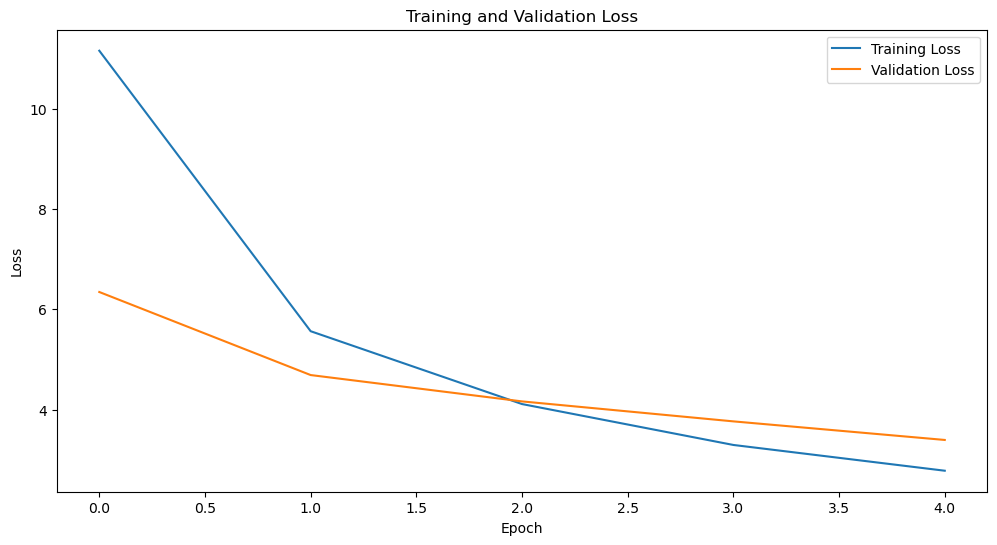

In [7]:
# Training and Validation loop

INPUT_SIZE = 784 # 28x28 pixels for each MNIST image
NUM_CLASSES = 10 # prediction 0-9 digits

learning_rate = 0.001
num_epochs = 5

train_losses = []
test_losses = []

model = MLP(input_size=INPUT_SIZE, num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X = X.to(device=device)
        y = y.to(device=device)
        X = X.reshape(X.shape[0], -1)
        optimiser.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * X.size(0) # accumulated loss for all batches 
    epoch_loss = running_loss/len(train_loader) # mean loss per sample in an epoch
    train_losses.append(epoch_loss)

    model.eval()
    running_loss = 0.0 
    all_preds = []
    all_actuals = []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device=device)
            y = y.to(device=device)
            X = X.reshape(X.shape[0], -1)
            logits = model(X)
            loss = criterion(logits, y)
            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_actuals.extend(y.cpu().numpy())

    epoch_test_loss = running_loss/len(test_loader)
    test_losses.append(epoch_test_loss)

    accuracy = accuracy_score(all_actuals, all_preds)
    f1 = f1_score(all_actuals, all_preds, average='weighted')

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()  